<a href="https://colab.research.google.com/github/ckiekim/Deep-Learning-with-Colab/blob/master/02_Cifar_100_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar-100
### Best Model 찾기

In [1]:
!mkdir model

In [2]:
!ls -l

total 8
drwxr-xr-x 2 root root 4096 Jul  7 05:32 model
drwxr-xr-x 1 root root 4096 Jun 26 16:26 sample_data


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import numpy as np
from tensorflow import keras
from keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = \
        cifar100.load_data(label_mode='fine')

Using TensorFlow backend.


169009152/169001437 [==============================] - 6s 0us/step


In [5]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

### 데이터 확인

In [6]:
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

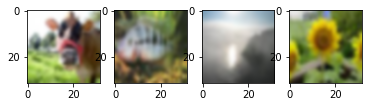

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [8]:
CIFAR100_LABELS[y_train[0][0]], CIFAR100_LABELS[y_train[4][0]], \
    CIFAR100_LABELS[y_train[8][0]], CIFAR100_LABELS[y_train[12][0]]

('cattle', 'aquarium_fish', 'cloud', 'sunflower')

### 자료형 변환 및 스케일링
- X: 실수형으로 정규화
- Y: 1-hot encoding

In [9]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_train.dtype)

(50000, 32, 32, 3) float32


In [10]:
Y_train = keras.utils.to_categorical(y_train, 100)
Y_test = keras.utils.to_categorical(y_test, 100)
Y_train[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

### 모형 구현

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Activation

In [12]:
model = Sequential()

# Input Layer
model.add(Conv2D(32, (3,3), padding='same', input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
# MAXPOOL Layer 1
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
# CONV2D Layer 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
# MAXPOOL Layer 2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
# Add a dropout of 10%
model.add(Dropout(0.1))
# CONV2D Layer 3
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
# MAXPOOL Layer 3
model.add(MaxPooling2D(pool_size=(2,2)))
# Add dropout of 25%
model.add(Dropout(0.25))
# flatten 
model.add(Flatten())
# Fully Connected Layer 1
model.add(Dense(512))
model.add(Activation('relu'))
# Adding a dropout of 50%
model.add(Dropout(0.5))
# Output Layer (Fully Connected Layer 2) 
model.add(Dense(100))
model.add(Activation('softmax'))
          
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

In [13]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, metrics=['accuracy'])

### Callback 선언

In [15]:
## to save checkpoint to use later
from keras.callbacks import ModelCheckpoint, EarlyStopping

modelpath = "model/cifar-100-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [16]:
history = model.fit(X_train, Y_train, epochs=300, batch_size=50,
                    validation_data=(X_test, Y_test), verbose=1,
                    callbacks=[checkpointer, early_stopping_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
50000/50000 [==============================] - 11s 230us/step - loss: 4.3479 - accuracy: 0.0418 - val_loss: 3.9557 - val_accuracy: 0.1109

Epoch 00001: val_loss improved from inf to 3.95573, saving model to model/cifar-100-001-3.9557.hdf5
Epoch 2/300
 1800/50000 [>.............................] - ETA: 4s - loss: 4.0127 - accuracy: 0.0928

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


50000/50000 [==============================] - 5s 103us/step - loss: 3.8730 - accuracy: 0.1110 - val_loss: 3.6009 - val_accuracy: 0.1688

Epoch 00002: val_loss improved from 3.95573 to 3.60095, saving model to model/cifar-100-002-3.6009.hdf5
Epoch 3/300
50000/50000 [==============================] - 5s 102us/step - loss: 3.6394 - accuracy: 0.1478 - val_loss: 3.4043 - val_accuracy: 0.2047

Epoch 00003: val_loss improved from 3.60095 to 3.40433, saving model to model/cifar-100-003-3.4043.hdf5
Epoch 4/300
50000/50000 [==============================] - 5s 105us/step - loss: 3.4728 - accuracy: 0.1767 - val_loss: 3.2510 - val_accuracy: 0.2330

Epoch 00004: val_loss improved from 3.40433 to 3.25096, saving model to model/cifar-100-004-3.2510.hdf5
Epoch 5/300
50000/50000 [==============================] - 5s 104us/step - loss: 3.3375 - accuracy: 0.2024 - val_loss: 3.1369 - val_accuracy: 0.2587

Epoch 00005: val_loss improved from 3.25096 to 3.13691, saving model to model/cifar-100-005-3.1369.h

In [17]:
from keras.models import load_model
del model
model = load_model('model/cifar-100-074-2.0040.hdf5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, metrics=['accuracy'])

In [20]:
# 테스트 정확도 출력 
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

10000/10000 [==============================] - 1s 88us/step

 Test Accuracy: 0.4869


### 결과 그래프로 확인하기

In [21]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

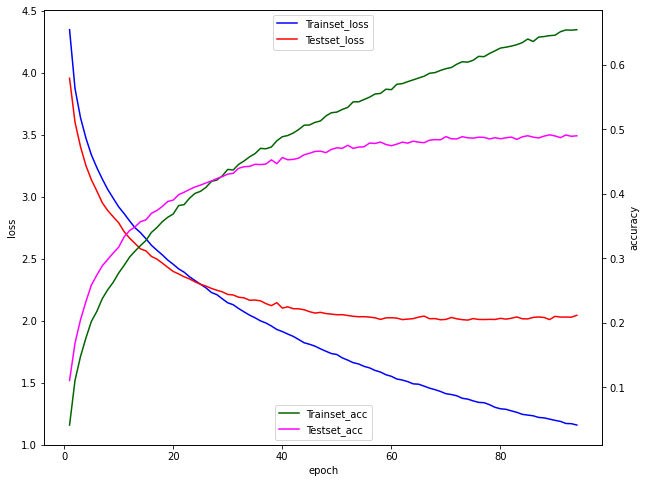

In [22]:
# 그래프로 표현
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper center')
ax1.legend(loc='lower center')
plt.show()

In [23]:
!ls -l model

total 258720
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-001-3.9557.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-002-3.6009.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-003-3.4043.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-004-3.2510.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-005-3.1369.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-006-3.0461.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:46 cifar-100-007-2.9509.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-008-2.8880.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-009-2.8382.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-010-2.7895.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-011-2.7178.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-012-2.6658.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-013-2.6230.hdf5
-rw-r--r-- 1 root root 4813232 Jul  7 05:47 cifar-100-014-2.5789.hdf5
-rw-r--